<a href="https://colab.research.google.com/github/Joana-Mansa/multilayer_perceptron/blob/Joana-Mansa-patch-1/multilayer_perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import the required packages**
Insert all the packages you require

In [ ]:
# import the required packages
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

## **Hyperparameters and Options**
Set the hyperparameters

In [ ]:
# HYPERPARAMETERS
batch_size = 10             # batch of the data
learning_rate = 3           # how fast we approach the minimum (learning step)
epochs = 10                 # number of epochs (1 epoch = 1 pass of all training data)
momentum = 0.1              # momentum factor (SGD optimizer)
lr_step_size = 100          # how much the learning rate decreases
lr_gamma = 0.1              # gamma factor (learning rate scheduler)
hidden_neurons = 16         # hidden units/neurons (of hidden layer)

# make visible only one GPU at the time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # <-- should be the ID of the GPU you want to use

# OPTIONS
device = "cuda:0"           # put here "cuda:0" if you want to run on GPU
display_first_n = 1         # how many samples/batches are displayed
num_workers = 4             # how many workers (=threads) for fetching data

# Train option
train_model = True          # to train a new model
print_performance = True    # to print the performance at each epoch
display_performance = True  # to display the performance at each epoch

# Test option
display_errors = True       # to display errors (only in Test mode)

## **Model architecture**
Define the network
- init: initialization of the fully connected (fc) layers of the network
- forward: phase where the input is propagated to the next levels, it provides the output of the network

In [ ]:
# DEFINE THE NETWORK:
# 1 input layer | 1 hidden layer | 1 output layer

# i included an extra hidden layer
# configurable inputs/hidden/outputs units (neurons)
class ShallowNet(nn.Module):

    # function where the fully connected (fc) layers of the network are defined
    def __init__(self, input_units, hidden_units, hidden_unit2, output_units):

        # super(): allow to avoid using the class name explicitly and
        # also working with Multiple Inheritance
        super(ShallowNet, self).__init__()

        # first fully connected layer
        self.fc1 = nn.Linear(input_units, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_unit2)


        # second fully connected layer
        self.fc3 = nn.Linear(hidden_unit2, output_units)

        # activation function
        self.act = nn.Sigmoid()

    # x represents our data
    def forward(self, x):

        # pass data through activation function in fc1
        x = self.act(self.fc1(x))

        # pass data (output of fc1) through activation function in fc2
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))



        # output data
        return x

## **Building blocks for training**
Instance of the network:
- Loss Function: to guide learning, quantify how close the actual output is to the desired output
- Optimizer: weight update method (stochastic gradient descent)
- Learning Rate Scheduler: adjust the learning rate based on the number of epochs

In [ ]:
# 784 inputs because MNIST images have size 28x28=784
# 10 outputs because MNIST images contain digits from 0 to 9
net = ShallowNet(784, hidden_neurons, hidden_neurons, 10)

# loss function: mean squared error (MSE)
criterion = nn.MSELoss()

# SGD optimizer: stochastic gradient descent
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

# learning rate scheduler: decreases learning rate of each parameter group by gamma every step_size
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

# EXPERIMENT ID
# original
#experiment_ID = "%s(%d)_%s_%s_bs(%d)lr(%.4f_%d_%.1f)m(%.1f)e(%d)" % (type(net).__name__, hidden_neurons, type(criterion).__name__, type(optimizer).__name__,
#                batch_size, learning_rate, lr_step_size, lr_gamma, momentum, epochs)

# ShallowNet(784-hidden_neurons-10)|criterion|optimizer|batch_size()|learning_rate(lr,lr_step_size,lr_gamma)|momentum|epochs)
experiment_ID = "%s(784-%d-10)|%s|%s|batch_size(%d)|learning_rate(%.4f_%d_%.1f)|momentum(%.1f)|epochs(%d)" % (type(net).__name__,
                                                                                                              hidden_neurons,
                                                                                                              type(criterion).__name__,
                                                                                                              type(optimizer).__name__,
                                                                                                              batch_size, learning_rate,
                                                                                                              lr_step_size,
                                                                                                              lr_gamma,
                                                                                                              momentum,
                                                                                                              epochs)

## **Create datasets**
Split training / validadion set.

*Note: in MNIST Dataset does not have a validation set, so the test set is used as validation set.*


In [ ]:
# DATASET: MNIST
dataset_train = torchvision.datasets.MNIST("./mnist", train=True, download=True)
dataset_valid = torchvision.datasets.MNIST("./mnist", train=False, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16435276.65it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 491034.25it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4559822.16it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5107380.37it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



## **Data Check**
The most recurring problem in Machine Learning and Deep Learning is that the model is fed with wrong data, caused by incorrect data loading, processinge ecc.

A good practice is to calculate and print statistics.


Train data are 60000, with shape torch.Size([60000, 28, 28])
...with mean 33.3 and standard deviation 78.6
...with labels tensor(5), tensor(0), tensor(4), ...

Validation data are 10000, with shape torch.Size([10000, 28, 28])
...with mean 33.8 and standard deviation 79.2
...with labels tensor(7), tensor(2), tensor(1), ...


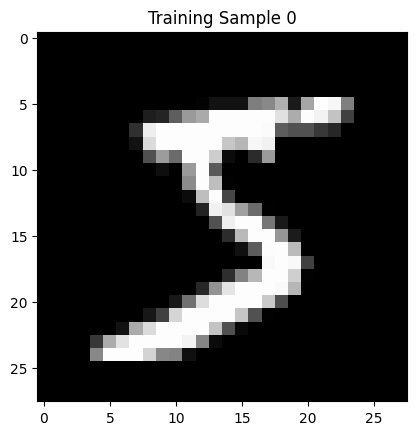

In [ ]:
# CHECK ORIGINAL DATA, before applying any transform
# NOTE: we also calculate data mean and standard deviation
print ("\nTrain data are %d, with shape %s" % (len(dataset_train), dataset_train.data.shape))
mu = dataset_train.data.float().mean() # mean (training set)
std = dataset_train.data.float().std() # standard deviation (training set)
print ("...with mean %.1f and standard deviation %.1f" % (mu, std))
print ("...with labels %s, %s, %s, ..." % (dataset_train.targets[0], dataset_train.targets[1], dataset_train.targets[2]))
mu_valid = dataset_valid.data.float().mean() # mean (validation set)
std_valid = dataset_valid.data.float().std() # standard deviation (validation set)
print ("\nValidation data are %d, with shape %s" % (len(dataset_valid), dataset_valid.data.shape))
print ("...with mean %.1f and standard deviation %.1f" % (mu_valid, std_valid))
print ("...with labels %s, %s, %s, ..." % (dataset_valid.targets[0], dataset_valid.targets[1], dataset_valid.targets[2]))

# Visual check
for i in range(0, display_first_n):
    plt.imshow(dataset_train.data[i], cmap='gray')
    plt.title('Training Sample %d' % i)
    plt.show()

## **Data transforms**
Data transforms are applied at batch generation time.

They serve to transform your data into what the neural network expects.

Data should be converted to tensors whose shape corresponds to the network input and possibly normalized so as to be 0-centered roughly in the [-1,1] range

In [ ]:
# TRANSFORM TO CONVERT MNIST IMAGES TO TORCH FLOAT TENSOR
# the operations are (in sequence):
# - 'np.array' to convert the image to a numpy array
# - 'torch.from_numpy' to convert the numpy array to torch tensor
# - 'torch.unsqueeze' to add a singleton channel dimension so as to have 1x28x28 instead of 28x28
#    since torchvision.transforms want CxHxW tensors
# - '.float()' to convert to float tensors, since deep learning builds on float numbers

# Convert transform to add a singleton channel dimension (CxHxW tensors)
class Convert(object):
    def __call__(self, img):
        return torch.unsqueeze(torch.from_numpy(np.array(img)), 0).float()

# Flatten transform so as to have a 28x28=784 tensor
class Flatten(object):
    def __call__(self, img):
        return img.view(28*28)

# Target transform so as to have a 1-hot tensor
class OneHot(object):
    def __call__(self, label):
        target = torch.zeros(10, dtype=torch.float)
        target[label] = 1.0
        return target

# define data transform as a composition of: Convert, Normalize, and Reshape
transform = transforms.Compose(
    [Convert(),                                       # Convert
     transforms.Normalize(mean=[mu], std=[std]),      # Normalize (implements standardization using mu and std, previously computed)
     Flatten()])                                      # Reshape

# set data and target transforms on both datasets
# NOTE: always use the SAME transforms on both training and validation/test sets
#       to avoid introducing biases
dataset_train.transform = transform
dataset_valid.transform = transform
dataset_train.target_transform = OneHot()
dataset_valid.target_transform = OneHot()

## **Data loaders**
Dataloaders are in-built PyTorch objects that serve to sample batches from datasets.

In [ ]:
# DATA LOADERS
# NOTE 1: shuffle helps training
# NOTE 2: in test mode, batch size can be as high as the GPU can handle (faster, but requires more GPU RAM)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=512, num_workers=num_workers, pin_memory=True)

## **Data check _after_ transforms**
To check what the network will see at train/test time, you have to use dataloaders which will apply the data transforms previously defined.

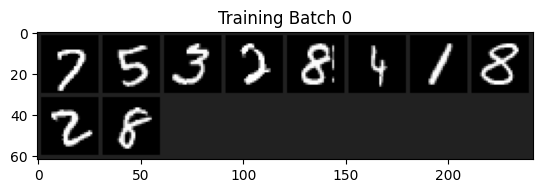

In [ ]:
# FUNCTION 'BATCH_SHOW' TO SHOW MNIST DATA
# where:
# - 'img' is a standardised tensor
# - tensor images are stored in channel-width-height (CWH) order
# - pyplot expects images to be in width-height-channel (WHC) order
def batch_show(img, batch_i):
    img = img*std + mu  # un-normalize
    img = img/255       # move data to [0,1] since pyplot expects float images to be in [0,1]
    npimg = img.numpy() # convert to numpy, since pyplot expects numpy images
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # CHW to WHC reshape
    plt.title('Training Batch %d' % batch_i)
    plt.show()

# Visual check
for i, minibatch in enumerate(dataloader_train):
    if i >= display_first_n:
        break
    data, labels = minibatch
    # data have size batch_size x 784, with .view we reshape
    # data so as to have batch_size x 1 (channel) x 28 x 28
    batch_show(torchvision.utils.make_grid(data.view(-1, 1, 28, 28)), i)

## **Train function**
It is preferable (but not mandatory) to embed training (1 epoch) code into a function, and call that function later during the training phase, at each epoch.

In [ ]:
# TRAIN FUNCTION (1 epoch)
def train(dataset, dataloader):

    # switch to train mode
    net.train()

    # reset performance measures
    loss_sum = 0.0
    correct = 0

    # 1 epoch = 1 complete loop over the dataset
    for batch in dataloader:

        # get data from dataloader
        inputs, targets = batch

        # move data to device
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)

        # zero (init) the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = net(inputs)

        # calculate loss
        loss = criterion(outputs, targets)

        # loss gradient backpropagation
        loss.backward()

        # net parameters update
        optimizer.step()

        # accumulate loss
        loss_sum += loss.item()

        # accumulate correct outputs (for accuracy calculation)
        outputs_max = torch.argmax(outputs, dim=1)
        targets_max = torch.argmax(targets, dim=1)
        correct += outputs_max.eq(targets_max).sum().float()

    # step learning rate scheduler
    scheduler.step()

    # return average loss and accuracy
    return loss_sum / len(dataloader), 100. * correct.item() / len(dataset)

## **Test function**
It is preferable (but not mandatory) to embed the test code into a function, and call that function whenever needed.

For instance, during training for validation at each epoch, or after training for testing, or for deploying the model.

In [ ]:
# TEST FUNCTION
def test(dataset, dataloader):

    # switch to test mode
    net.eval()

    # initialize predictions
    predictions = torch.zeros(len(dataset), dtype=torch.int64)
    sample_counter = 0

    # do not accumulate gradients (faster)
    with torch.no_grad():

        # test all batches
        for batch in dataloader:

            # get data from dataloader [ignore labels/targets as they are not used in test mode]
            inputs = batch[0]

            # move data to device
            inputs = inputs.to(device, non_blocking=True)

            # forward pass
            outputs = net(inputs)

            # store predictions
            outputs_max = torch.argmax(outputs, dim=1)
            for output in outputs_max:
                predictions[sample_counter] = output
                sample_counter += 1

    # return predictions
    return predictions

## **Train Model / Test Model**
The code below also includes visual loss/accuracy monitoring during training, both on training and validation sets.


EPOCH 1
TIME: 30.8 seconds
LOSS: 0.0346015 (best 0.0346015 at epoch 1)
TRAINING ACCURACY: 76.32% (best 76.32% at epoch 1)
VALIDATION ACCURACY: 89.87% (best 89.87% at epoch 1)


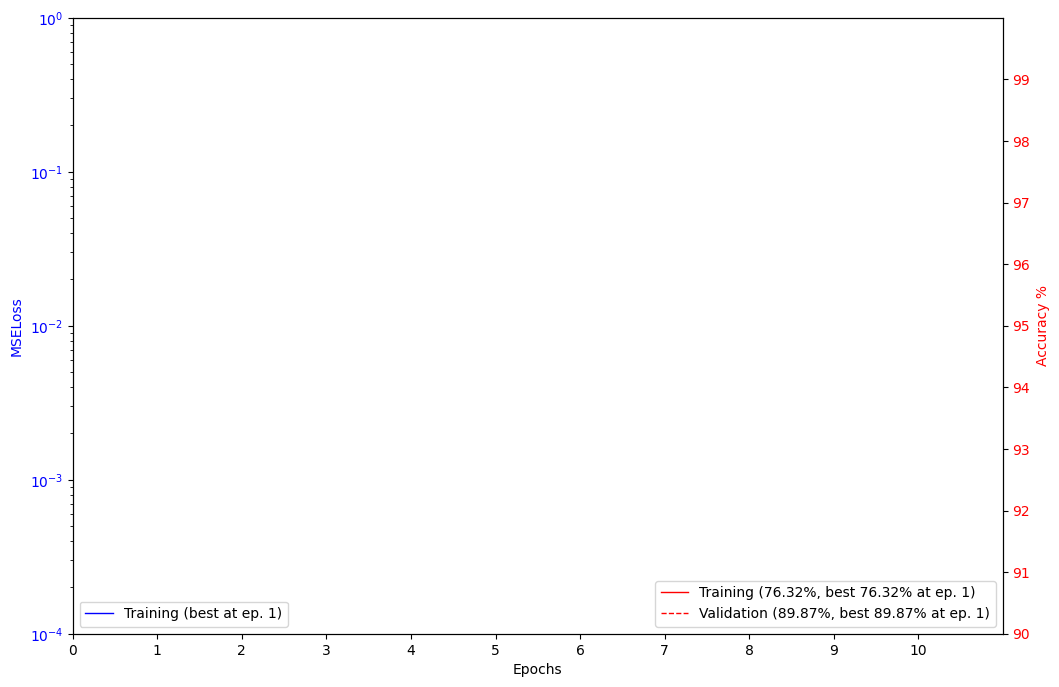


EPOCH 2
TIME: 29.3 seconds
LOSS: 0.0146898 (best 0.0146898 at epoch 2)
TRAINING ACCURACY: 90.81% (best 90.81% at epoch 2)
VALIDATION ACCURACY: 91.44% (best 91.44% at epoch 2)


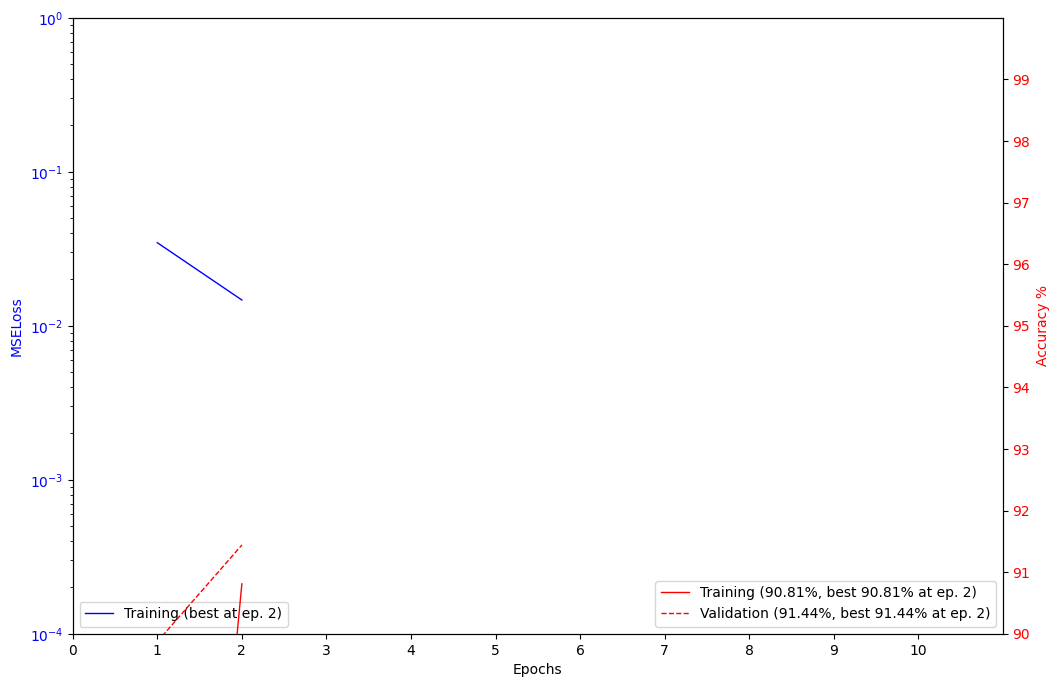


EPOCH 3
TIME: 30.2 seconds
LOSS: 0.0131214 (best 0.0131214 at epoch 3)
TRAINING ACCURACY: 91.75% (best 91.75% at epoch 3)
VALIDATION ACCURACY: 91.28% (best 91.44% at epoch 2)


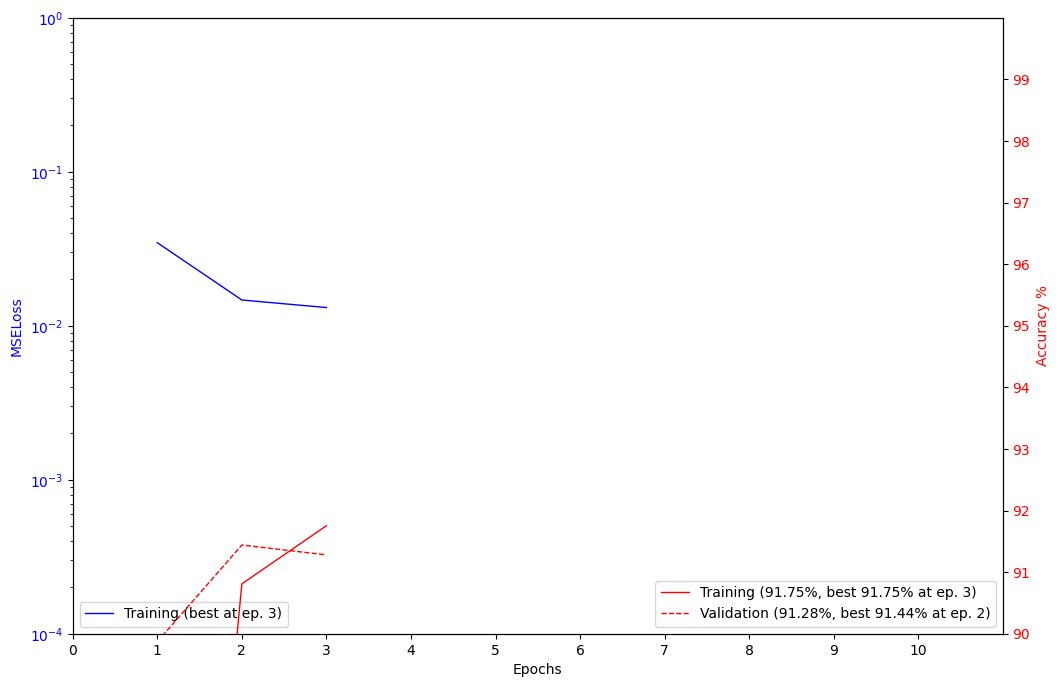


EPOCH 4
TIME: 29.4 seconds
LOSS: 0.0121055 (best 0.0121055 at epoch 4)
TRAINING ACCURACY: 92.37% (best 92.37% at epoch 4)
VALIDATION ACCURACY: 92.18% (best 92.18% at epoch 4)


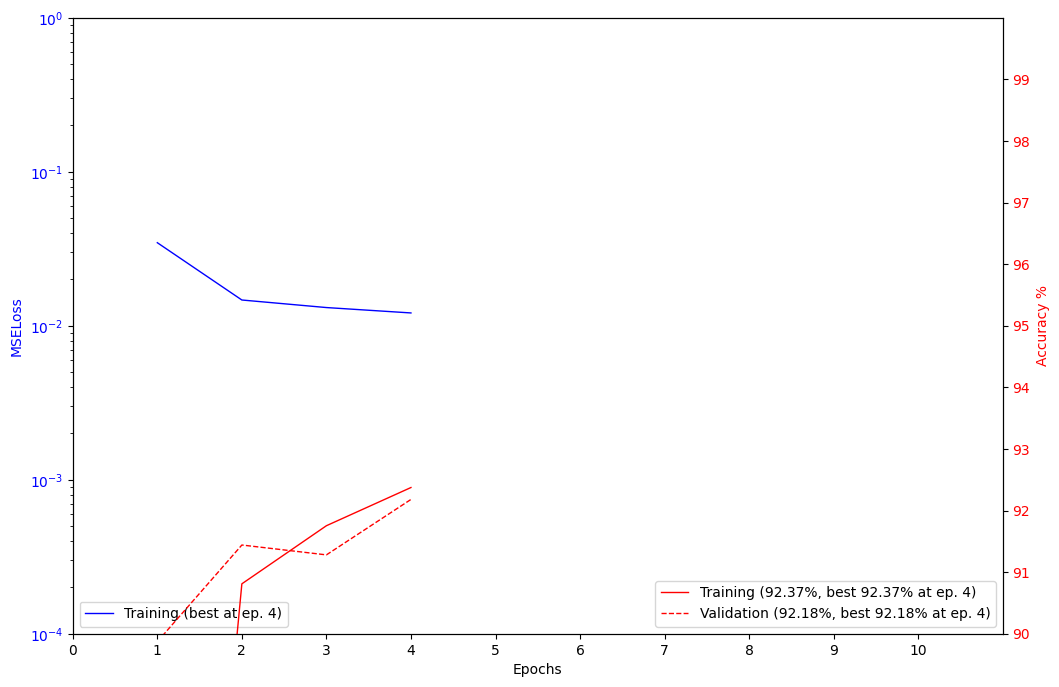


EPOCH 5
TIME: 30.4 seconds
LOSS: 0.0114124 (best 0.0114124 at epoch 5)
TRAINING ACCURACY: 92.86% (best 92.86% at epoch 5)
VALIDATION ACCURACY: 92.65% (best 92.65% at epoch 5)


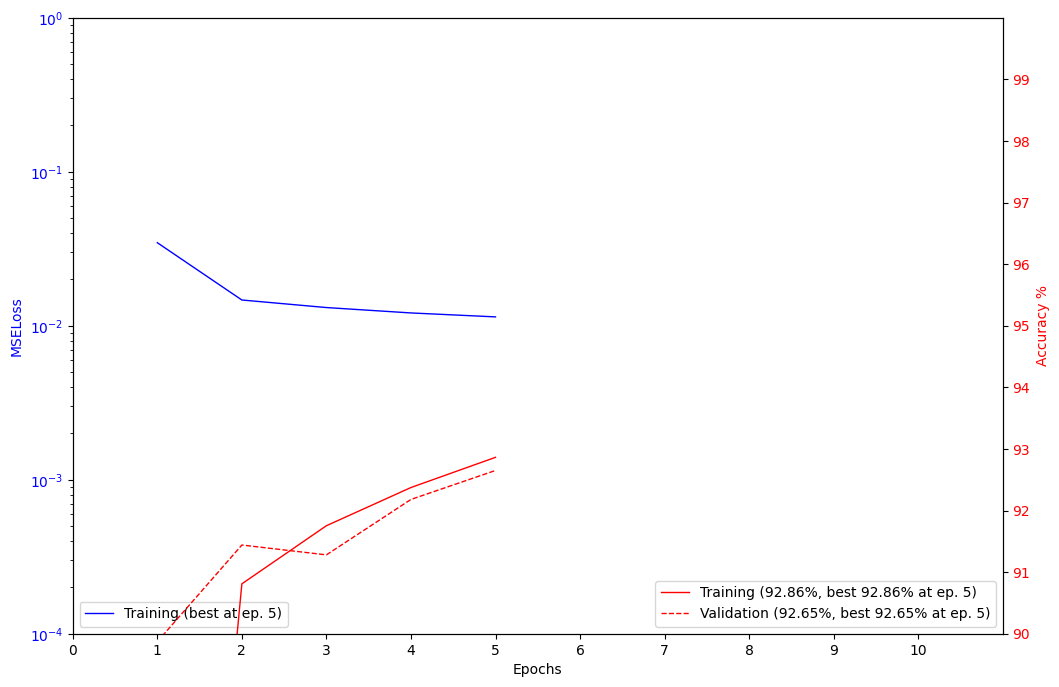


EPOCH 6
TIME: 29.5 seconds
LOSS: 0.0109233 (best 0.0109233 at epoch 6)
TRAINING ACCURACY: 93.20% (best 93.20% at epoch 6)
VALIDATION ACCURACY: 93.20% (best 93.20% at epoch 6)


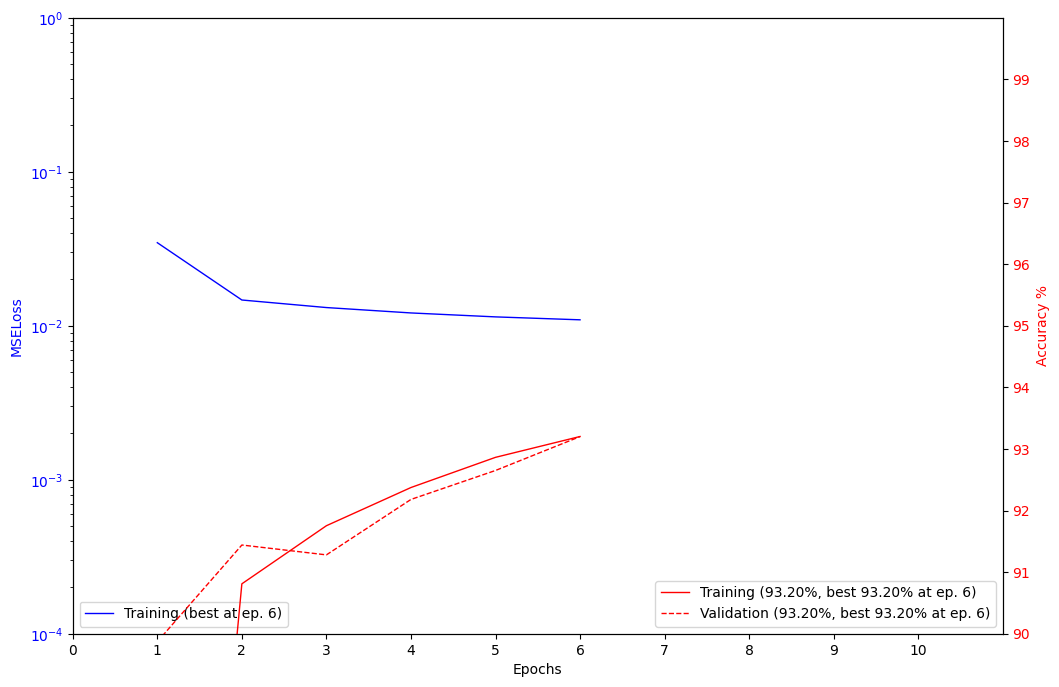


EPOCH 7
TIME: 30.2 seconds
LOSS: 0.0104401 (best 0.0104401 at epoch 7)
TRAINING ACCURACY: 93.46% (best 93.46% at epoch 7)
VALIDATION ACCURACY: 92.30% (best 93.20% at epoch 6)


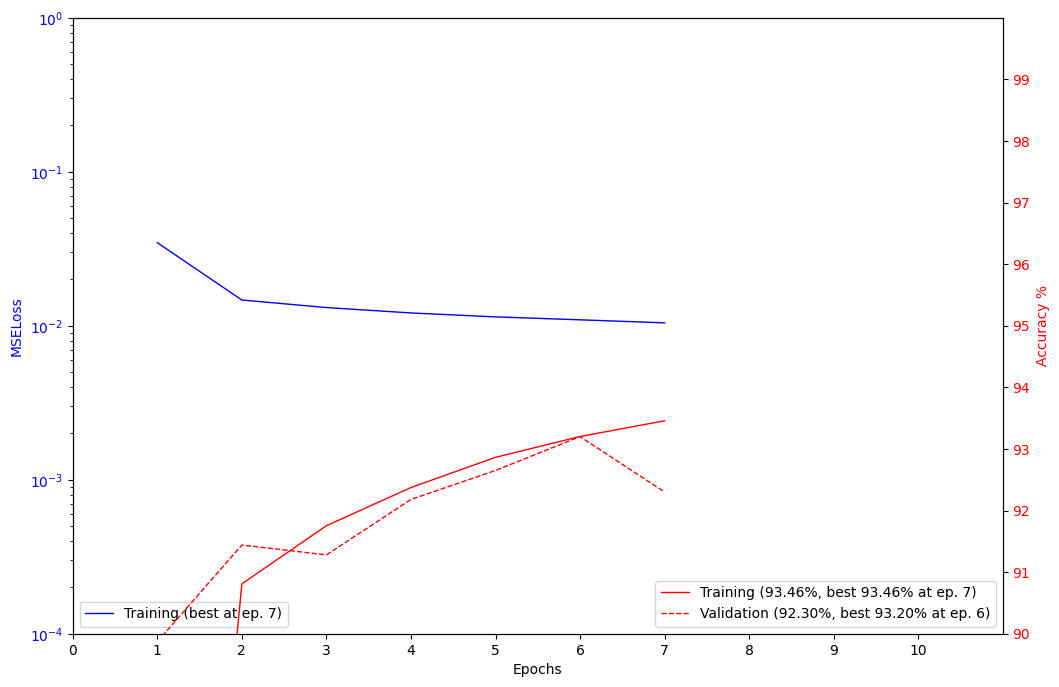


EPOCH 8
TIME: 30.2 seconds
LOSS: 0.0102351 (best 0.0102351 at epoch 8)
TRAINING ACCURACY: 93.62% (best 93.62% at epoch 8)
VALIDATION ACCURACY: 93.14% (best 93.20% at epoch 6)


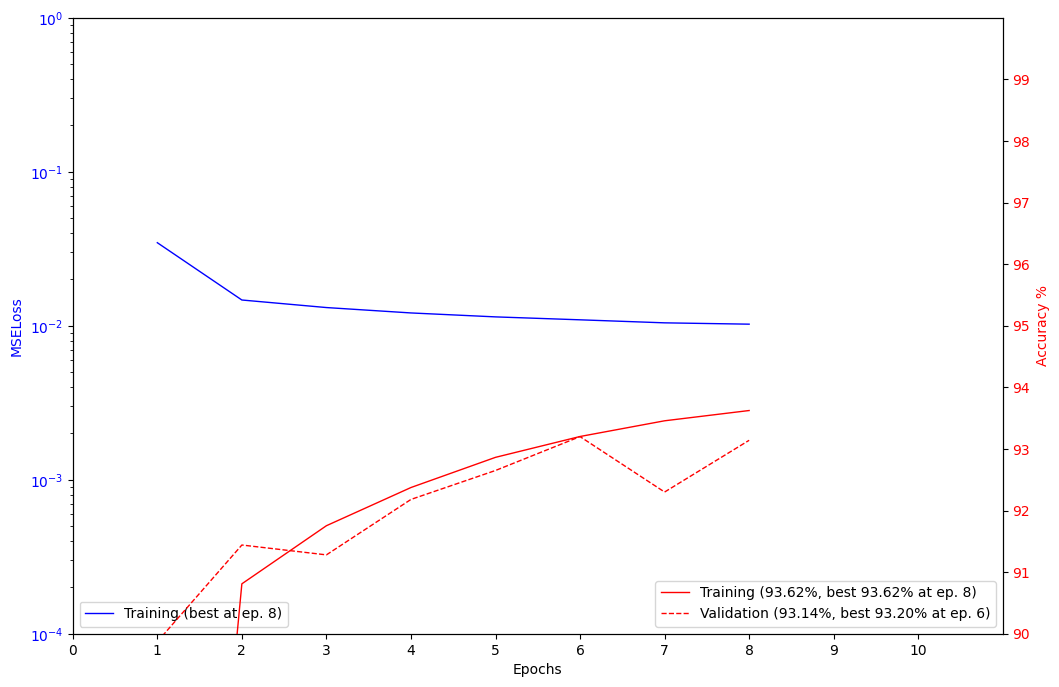


EPOCH 9
TIME: 29.8 seconds
LOSS: 0.0100142 (best 0.0100142 at epoch 9)
TRAINING ACCURACY: 93.81% (best 93.81% at epoch 9)
VALIDATION ACCURACY: 93.47% (best 93.47% at epoch 9)


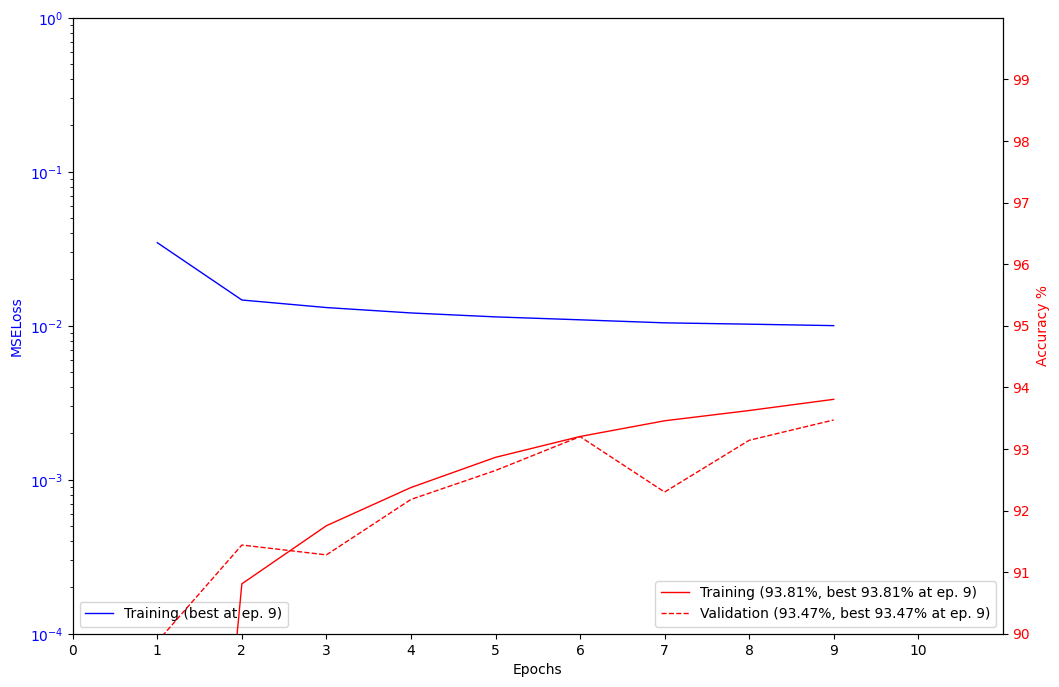


EPOCH 10
TIME: 29.5 seconds
LOSS: 0.00979723 (best 0.00979723 at epoch 10)
TRAINING ACCURACY: 93.95% (best 93.95% at epoch 10)
VALIDATION ACCURACY: 92.92% (best 93.47% at epoch 9)


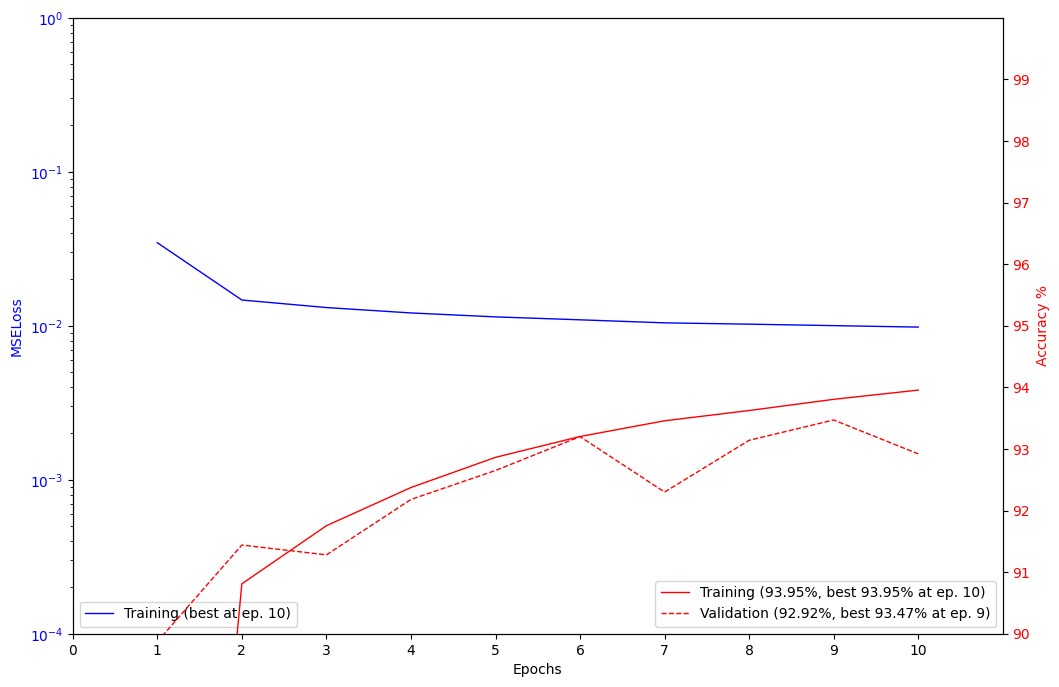





FINAL PERFORMANCE 




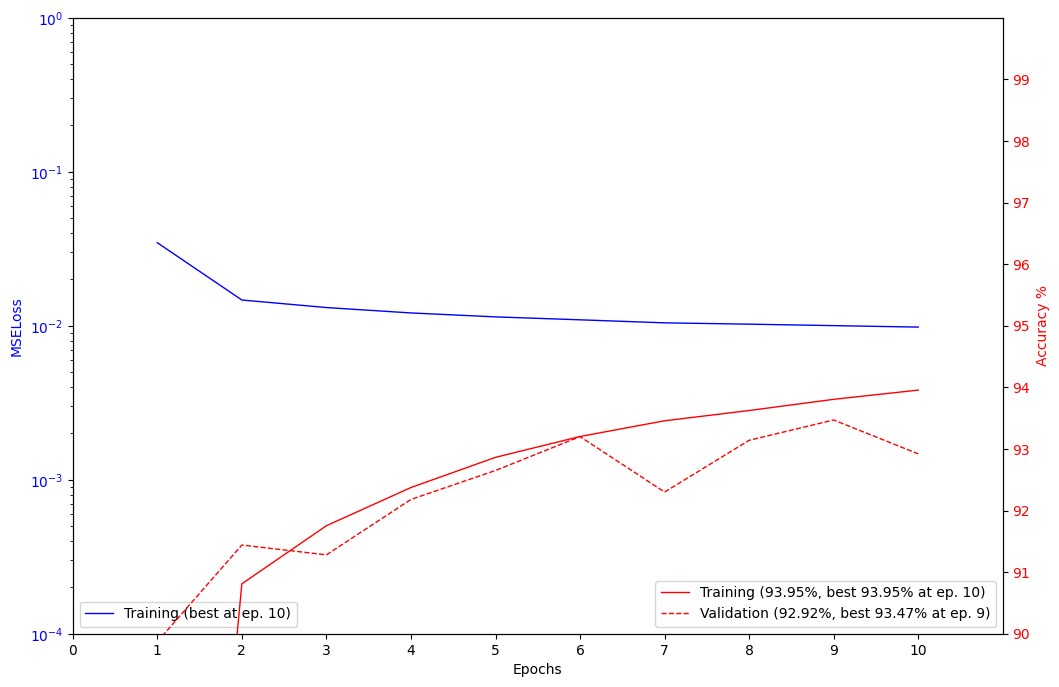

In [ ]:
# train_model TRUE -> TRAIN MODEL
if train_model:

    # init performance monitors
    losses = []
    train_accuracies = []
    valid_accuracies = []
    ticks = []

    # move net to device
    net.to(device)

    # start training
    for epoch in range(1, epochs+1):

        # measure time elapsed
        t0 = time.time()

        # TRAIN
        avg_loss, accuracy_train = train(dataset_train, dataloader_train)

        # TEST on validation set
        predictions = test(dataset_valid, dataloader_valid)
        accuracy_valid = 100. * predictions.eq(dataset_valid.targets).sum().float() / len(dataset_valid)

        # update performance history
        losses.append(avg_loss)
        train_accuracies.append(accuracy_train)
        valid_accuracies.append(accuracy_valid)
        ticks.append(epoch)

        # PERFORMANCE
        if print_performance:
            # Print Performance
            print ("\nEPOCH %d\n"
                "TIME: %.1f seconds\n"
                "LOSS: %g (best %g at epoch %d)\n"
                "TRAINING ACCURACY: %.2f%% (best %.2f%% at epoch %d)\n"
                "VALIDATION ACCURACY: %.2f%% (best %.2f%% at epoch %d)" % (
                epoch,
                time.time()-t0,
                avg_loss, min(losses), ticks[np.argmin(losses)],
                accuracy_train, max(train_accuracies), ticks[np.argmax(train_accuracies)],
                accuracy_valid, max(valid_accuracies), ticks[np.argmax(valid_accuracies)]))

        if display_performance:
            # Display Performance
            fig, ax1 = plt.subplots(figsize=(12, 8), num=1)
            ax1.set_xticks(np.arange(0, epochs+1, step=epochs/10.0))
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel(type(criterion).__name__, color='blue')
            ax1.set_ylim(0.0001, 1)
            ax1.tick_params(axis='y', labelcolor='blue')
            ax1.set_yscale('log')
            ax1.plot(ticks, losses, 'b-', linewidth=1.0, aa=True,
                label='Training (best at ep. %d)' % ticks[np.argmin(losses)])
            ax1.legend(loc="lower left")
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            ax2.set_ylabel('Accuracy %', color='red')
            ax2.set_ylim(90, 100)
            ax2.set_yticks(np.arange(90, 100, step=1))
            ax2.tick_params(axis='y', labelcolor='red')
            ax2.plot(ticks, train_accuracies, 'r-', linewidth=1.0, aa=True,
                label='Training (%.2f%%, best %.2f%% at ep. %d)' % (accuracy_train, max(train_accuracies), ticks[np.argmax(train_accuracies)]))
            ax2.plot(ticks, valid_accuracies, 'r--', linewidth=1.0, aa=True,
                label='Validation (%.2f%%, best %.2f%% at ep. %d)' % (accuracy_valid, max(valid_accuracies), ticks[np.argmax(valid_accuracies)]))
            ax2.legend(loc="lower right")
            plt.xlim(0, epochs+1)

            plt.draw()
            #plt.pause(0.001)
            plt.show()
            fig.clear()

        # save model if validation performance has improved
        if (epoch-1) == np.argmax(valid_accuracies):
            torch.save({
                'net': net,
                'accuracy': max(valid_accuracies),
                'epoch': epoch
            }, experiment_ID + ".tar")

    # Display Final Performance
    print ("\n\n")
    print ("==================\n")
    print ("FINAL PERFORMANCE \n")
    print ("==================\n")

    fig, ax1 = plt.subplots(figsize=(12, 8), num=1)
    ax1.set_xticks(np.arange(0, epochs+1, step=epochs/10.0))
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(type(criterion).__name__, color='blue')
    ax1.set_ylim(0.0001, 1)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_yscale('log')
    ax1.plot(ticks, losses, 'b-', linewidth=1.0, aa=True,
        label='Training (best at ep. %d)' % ticks[np.argmin(losses)])
    ax1.legend(loc="lower left")
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Accuracy %', color='red')
    ax2.set_ylim(90, 100)
    ax2.set_yticks(np.arange(90, 100, step=1))
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.plot(ticks, train_accuracies, 'r-', linewidth=1.0, aa=True,
        label='Training (%.2f%%, best %.2f%% at ep. %d)' % (accuracy_train, max(train_accuracies), ticks[np.argmax(train_accuracies)]))
    ax2.plot(ticks, valid_accuracies, 'r--', linewidth=1.0, aa=True,
        label='Validation (%.2f%%, best %.2f%% at ep. %d)' % (accuracy_valid, max(valid_accuracies), ticks[np.argmax(valid_accuracies)]))
    ax2.legend(loc="lower right")
    plt.xlim(0, epochs+1)

    plt.draw()
    #plt.pause(0.001)
    plt.savefig(experiment_ID + ".png", dpi=300)
    plt.show()
    fig.clear()

# train_model FALSE -> TEST MODEL
else:

    # LOAD PRETRAINED MODEL
    checkpoint = torch.load(experiment_ID + ".tar", map_location=lambda storage, loc: storage)
    net = checkpoint['net']
    print ("LOADED PRETRAINED MODEL\n")
    print ("(Trained for %d epochs\n Accuracy: %.2f)" % (checkpoint['epoch'], checkpoint['accuracy']))

    # move net to device
    net.to(device)

    # TEST
    predictions = test(dataset_valid, dataloader_valid)
    accuracy = 100. * predictions.eq(dataset_valid.targets).sum().float() / len(dataset_valid)
    print ("ACCURACY ON TEST SET IS %.2f" % accuracy)

    # DISPLAY ERRORS
    if display_errors:

        # predictions / target comparisons = 1 for match, 0 for mismatch
        # we subtract 1, so we have 0 for match, -1 for mismatch
        # nonzero elements are thus all mismatches
        errors = torch.nonzero(torch.logical_not(predictions.eq(dataset_valid.targets)))

        print ("NUMBERS OF ERRORS: ", len(errors))

        # get errors samples and convert them to torch tensors
        error_samples = torch.zeros(len(errors), 1, 28, 28)
        conversion = Convert()
        for i, e in enumerate(errors):
            error_samples[i] = conversion(dataset_valid.data[e.item()])

        # make a grid of images and show
        img = torchvision.utils.make_grid(error_samples, nrow=20)
        img = img/255       # move data to [0,1] since pyplot expects float images to be in [0,1]
        npimg = img.numpy() # convert to numpy, since pyplot expects numpy images
        plt.imshow(np.transpose(npimg, (1, 2, 0)))  # CHW to WHC reshape
        plt.title('Errors')
        plt.savefig("Errors" + ".png", dpi=300)
        plt.show()